#Импорт библитек и данных

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, roc_curve, precision_recall_curve, average_precision_score
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE

from google.colab import drive

In [ ]:
drive.mount('/content/drive')
data_path = "/content/drive/MyDrive/Datasets/SMSSpamCollection.csv"
df = pd.read_csv(data_path, sep='\t', header=None, names=['label', 'text'])
df

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


#Обработка данных

In [ ]:
# Преобразование меток в числовой формат
df['label'] = df['label'].map({'ham': 0, 'spam': 1})

In [ ]:
# Разделение данных на признаки и метки
X = df['text']
y = df['label']

In [ ]:
y.value_counts()

label
0    4825
1     747
Name: count, dtype: int64

In [ ]:
# Векторизация текстовых данных
vectorizer = TfidfVectorizer(ngram_range=(1, 2))
X_vectorized = vectorizer.fit_transform(X)

In [ ]:
X_vectorized.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
# Разделение данных на обучающий и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(X_vectorized, y, test_size=0.2, random_state=42)

In [ ]:
# Преобразование меток в числовой формат
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)

In [ ]:
# SMOTE с sampling_strategy для балансировки классов
smote = SMOTE(sampling_strategy='minority')
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

<class 'scipy.sparse._csr.csr_matrix'>
(7718, 50506)
350976
['00' '00 in' '00 per' '00 sub' '00 subs' '000' '000 bonus' '000 cash'
 '000 homeowners' '000 pounds']


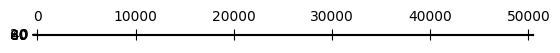

In [ ]:
# Проверка формата данных
print(type(X_train_resampled))
print(X_train_resampled.shape)
print(X_train_resampled.nnz)
print(vectorizer.get_feature_names_out()[:10]) # первые 10 признаков
plt.spy(X_train_resampled[:100])  # Визуализация первых 100 документов
plt.show()

Эти модели относятся к классу алгоритмов машинного обучения, которые используются для классификации данных. Когда у нас есть набор данных, и мы хотим научить компьютер распознавать, к какому классу (категории) принадлежат новые данные, мы можем использовать эти модели.

Вот как они работают:

1. **Gaussian Naive Bayes (Гауссовский наивный Байес):** Этот метод основан на предположении о том, что значения каждого признака (или характеристики) данных подчиняются нормальному (гауссовскому) распределению. Он эффективен, когда данные имеют непрерывные значения.

2. **Multinomial Naive Bayes (Мультиномиальный наивный Байес):** Этот алгоритм хорошо работает с данными, где признаки описываются целыми числами и представляют собой количество определенных событий (например, количество слов в тексте). Он часто используется в анализе текстов.

3. **Bernoulli Naive Bayes (Бернуллиевский наивный Байес):** Этот метод хорошо подходит для работы с данными, где признаки бинарные (т.е. принимают только два значения, например, 0 и 1). Он часто используется в задачах классификации текста, где мы можем представить слова как наличие или отсутствие в документе.

Таким образом, эти модели помогают автоматически обучать компьютер распознавать и классифицировать данные в соответствии с их признаками, что может быть полезно во многих областях, таких как медицина, финансы, анализ текстов и многое другое.

In [ ]:
models = {
    "Gaussian Naive Bayes": GaussianNB(),
    "Multinomial Naive Bayes": MultinomialNB(),
    "Bernoulli Naive Bayes": BernoulliNB()
}

#Функция подсчёта метрик

In [ ]:
# Функция подсчета метрик
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, precision_recall_curve

def calculate_metrics(y_true, y_pred, model_name):
    """
    Функция для подсчета метрик качества модели бинарной классификации.

    Аргументы:
    y_true: Массив истинных меток.
    y_pred: Массив предсказанных меток.
    model_name: Название модели.

    Возвращает:
    metrics_dict: Словарь с названием метрик, их значениями и названием модели.
    """

    # Вычисляем метрики
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    # ROC кривая и площадь под кривой
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)

    # PR кривая и площадь под кривой
    precision_curve, recall_curve, _ = precision_recall_curve(y_true, y_pred)
    pr_auc = auc(recall_curve, precision_curve)

    # Собираем метрики в словарь
    metrics_dict = {
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'ROC AUC': roc_auc,
        'PR AUC': pr_auc
    }

    return metrics_dict


# Обучаем модели и строим графики

PR (Precision-Recall) и ROC (Receiver Operating Characteristic) кривые - это графические инструменты для оценки производительности классификационных моделей.

PR кривая показывает отношение между точностью (precision) и полнотой (recall) для различных порогов классификации. Precision - это доля верно классифицированных положительных объектов среди всех объектов, которые были предсказаны как положительные. Recall - это доля верно классифицированных положительных объектов среди всех реальных положительных объектов. PR кривая полезна, когда классы несбалансированы, и когда ложноположительные и ложноотрицательные ошибки имеют разную стоимость.

ROC кривая показывает отношение между чувствительностью (true positive rate) и специфичностью (1 - false positive rate) для различных порогов классификации. Чувствительность (true positive rate) - это доля верно классифицированных положительных объектов среди всех реальных положительных объектов. Специфичность (1 - false positive rate) - это доля верно классифицированных отрицательных объектов среди всех реальных отрицательных объектов. ROC кривая полезна для оценки производительности модели при различных порогах классификации и при различной важности ложноположительных и ложноотрицательных ошибок.

Обе кривые могут быть использованы для выбора оптимального порога классификации в зависимости от целей задачи и предпочтений по торговле между чувствительностью и специфичностью или точностью и полнотой.

In [ ]:
# Подбор оптимального порога ROC кривой
def find_optimal_threshold(fpr, tpr, thresholds):
    # Вычисление значений Youden's J statistic для каждого порога
    j_scores = tpr - fpr
    # Находим индекс порога с максимальным значением J statistic
    idx = np.argmax(j_scores)
    optimal_threshold = thresholds[idx]
    return optimal_threshold

Model (Gaussian Naive Bayes): Gaussian Naive Bayes
Accuracy (Gaussian Naive Bayes): 0.968609865470852
Precision (Gaussian Naive Bayes): 0.8653846153846154
Recall (Gaussian Naive Bayes): 0.9060402684563759
F1 Score (Gaussian Naive Bayes): 0.8852459016393444
ROC AUC (Gaussian Naive Bayes): 0.9422
PR AUC (Gaussian Naive Bayes): 0.8920



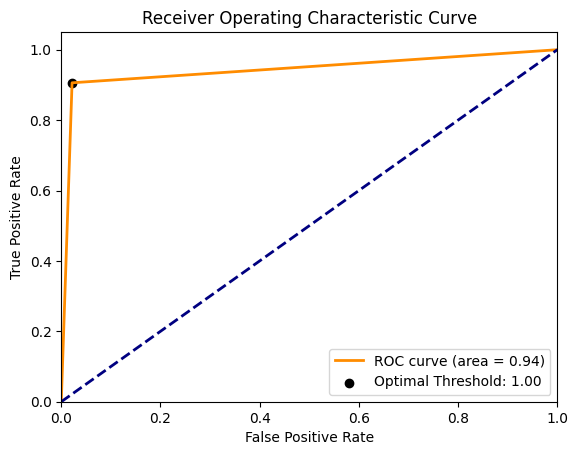

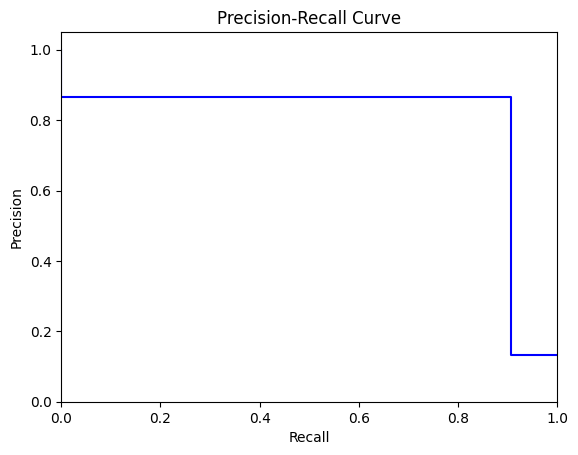

Model (Multinomial Naive Bayes): Multinomial Naive Bayes
Accuracy (Multinomial Naive Bayes): 0.9865470852017937
Precision (Multinomial Naive Bayes): 0.9407894736842105
Recall (Multinomial Naive Bayes): 0.959731543624161
F1 Score (Multinomial Naive Bayes): 0.9501661129568106
ROC AUC (Multinomial Naive Bayes): 0.9752
PR AUC (Multinomial Naive Bayes): 0.9530



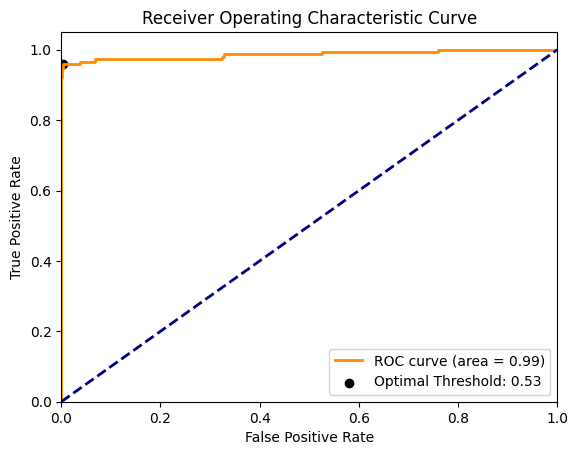

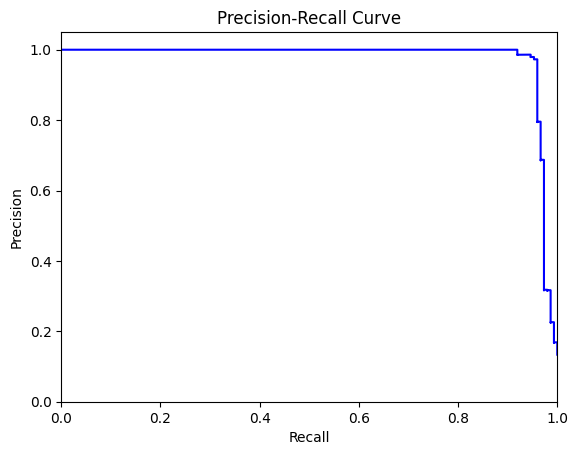

Model (Bernoulli Naive Bayes): Bernoulli Naive Bayes
Accuracy (Bernoulli Naive Bayes): 0.9757847533632287
Precision (Bernoulli Naive Bayes): 1.0
Recall (Bernoulli Naive Bayes): 0.8187919463087249
F1 Score (Bernoulli Naive Bayes): 0.900369003690037
ROC AUC (Bernoulli Naive Bayes): 0.9094
PR AUC (Bernoulli Naive Bayes): 0.9215



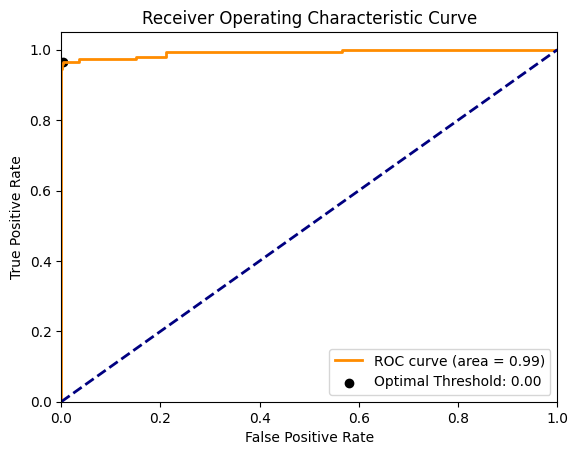

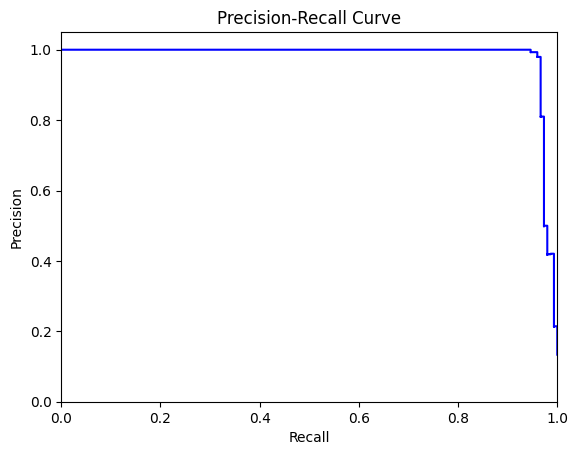

In [ ]:
# Список для хранения результатов
all_metrics = []
optimal_thresholds = []

for name, model in models.items():
    # Преобразуем данные в плотный массив
    X_train_dense = X_train_resampled.toarray()
    model.fit(X_train_dense, y_train_resampled) # Обучение на сбалансированных данных

    # Предсказание меток для тестового набора данных
    y_pred = model.predict(X_test.toarray())
    y_pred_proba = model.predict_proba(X_test.toarray())[:, 1]

    # Вызов функции calculate_metrics для подсчета метрик качества
    metrics = calculate_metrics(y_test, y_pred, name)

    # Добавление метрик текущей модели в список
    all_metrics.append(metrics)

    # Вывод результатов
    for metric_name, metric_value in metrics.items():
        if metric_name in ['ROC AUC', 'PR AUC']:
            print(f"{metric_name} ({metrics['Model']}): {metric_value:.4f}")
        else:
            print(f"{metric_name} ({metrics['Model']}): {metric_value}")
    print()

    # Подбор оптимального порога для текущей модели
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    optimal_threshold = find_optimal_threshold(fpr, tpr, thresholds)
    optimal_thresholds.append(optimal_threshold)

    # Построение ROC кривой с использованием оптимального порога
    plt.figure()
    # Вычисление площади под кривой ROC
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.scatter(fpr[np.argmax(tpr - fpr)], tpr[np.argmax(tpr - fpr)], marker='o', color='black', label=f'Optimal Threshold: {optimal_threshold:.2f}')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend(loc="lower right")
    plt.show()

    # Построение PR кривой
    precision, recall, _ = precision_recall_curve(y_test, model.predict_proba(X_test.toarray())[:,1])
    pr_auc = auc(recall, precision)
    plt.figure()
    plt.step(recall, precision, color='b', where='post')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall Curve')
    plt.show()


#Анализ результатов и выбор лучшей модели
Исходя из представленных метрик, можно сделать следующие выводы:
* *Multinomial Naive Bayes* демонстрирует наилучшие результаты по большинству метрик:
    1. **Accuracy** (точность): 98.65% - самый высокий процент правильных классификаций.
    2. **Precision** (точность): 94.08% - высокая доля правильно классифицированных спам-сообщений среди всех сообщений, которые были предсказаны как спам.
    3. **Recall** (полнота): 95.97% - высокая доля правильно классифицированных спам-сообщений среди всех реальных спам-сообщений.
    4. **F1 Score**: 95.02% - хороший баланс между точностью и полнотой.
    5. **ROC AUC**: 97.52% - высокая площадь под ROC-кривой, что указывает на хорошую способность модели различать классы.
    6. **PR AUC**: 95.3% - высокая площадь под PR-кривой, что указывает на хорошую производительность модели, особенно при учете несбалансированности классов.

* *Bernoulli Naive Bayes* показывает высокую точность (100%), но значительно более низкую полноту (81.88%), что может быть проблемой, если важно обнаруживать как можно больше спам-сообщений.

* *Gaussian Naive Bayes* имеет показатели, немного уступающие Multinomial Naive Bayes, но все же демонстрирует хорошие результаты.

###Вывод:
В целом, Multinomial Naive Bayes является наилучшей моделью для данной задачи, так как он демонстрирует наилучший баланс между точностью, полнотой и другими метриками.